In [1]:
# Packages necessary for this notebook
import numpy             as np
import pandas            as pd
import xarray            as xr
import seaborn           as sns
import cartopy.crs       as crs
import cartopy.feature   as cfeature
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# Import the NOAA data from 1981-2019
NOAA = xr.open_dataset(r'D:\CRI_Modelling_PC\Netcdf Data\NOAA\sst.day.mean.PacCst.1981-2019.nc')

In [3]:
# Put in your temperature ranges here:
# All temperatures in Celcius
min_Temp = 5
max_Temp = 17.6

In [4]:
# Get lat and lon data
lat = NOAA.lat.data
lon = NOAA.lon.data

In [5]:
NOAA_years = np.where((pd.DatetimeIndex(NOAA.time.data).year>=1982) & (pd.DatetimeIndex(NOAA.time.data).year<=2018))
NOAA_short = NOAA.sst[(NOAA_years[0]),:,:]

In [6]:
# Create a mask for land, count the days, and average them over years
NOAA_Mask  = NOAA.sst.where(NOAA.sst.isnull(), 1)
NOAA_Count = NOAA_short.where((NOAA_short <= max_Temp) & (NOAA_short >= min_Temp)).groupby('time.year').count(dim='time')
count_Mean = NOAA_Count.mean(dim="year")
NOAA_Final = count_Mean*NOAA_Mask[0,:,:]

In [15]:
NOAA_Years  = NOAA_short.groupby('time.year')
Yearly_Mean = NOAA_Years.mean(dim="time")*NOAA_Mask[0,:,:]

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [24]:
Yearly_Mean.year

<xarray.DataArray 'year' (year: 37)>
array([1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018], dtype=int64)
Coordinates:
  * year     (year) int64 1982 1983 1984 1985 1986 ... 2014 2015 2016 2017 2018
    time     datetime64[ns] 1981-09-01

In [10]:
# Just for getting state lines 
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

In [27]:
# Make a list of years from 0 - 36 to be used as our 'x'

years = [None]*(len(Yearly_Mean.year.data))
for ii in range(len(Yearly_Mean.year.data)):
    years[ii] = ii

In [39]:
# Initialize a list of slopes to be used as 'y'

NOAA_Slopes = NOAA_Final.copy()

for ii in range(200):
    for jj in range(240):
        NOAA_Slopes[ii][jj] = 0

In [40]:
# Populate NOAA_Slopes with linear regression

for ii in range(200):
    for kk in range(240):
        slope, intercept, r_value, p_value, std_err =  stats.linregress(years,Yearly_Mean[:,ii,kk].data)
        NOAA_Slopes[ii][kk] = slope

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


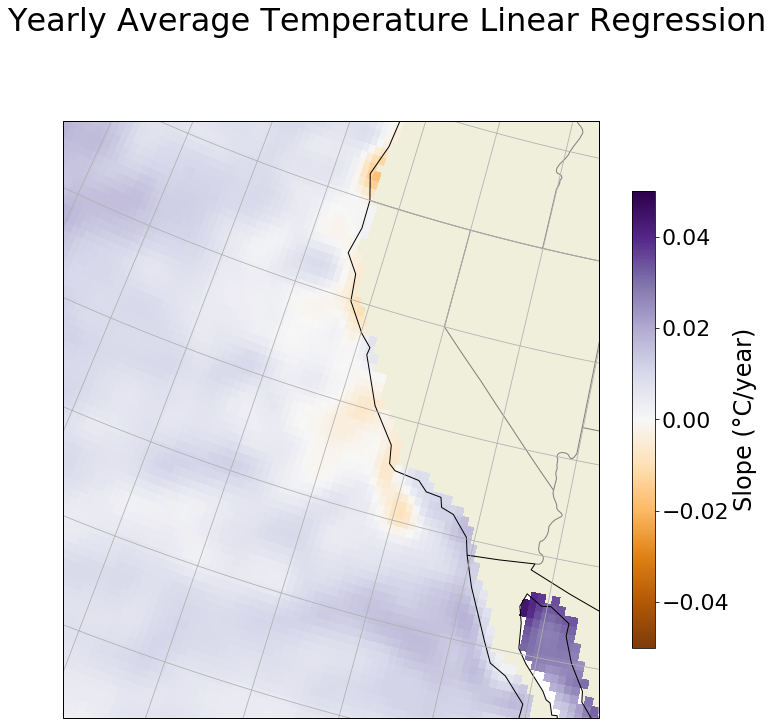

In [46]:
fig = plt.figure(figsize=[12,12])
fig.suptitle('Yearly Average Temperature Linear Regression',fontsize=32)

# Plot the count_Mean data
linreg_Plot = fig.add_subplot(1,1,1,projection=crs.LambertConformal())
linreg_Plot.set_extent([230,245,28,43], crs.Geodetic())
linreg_Colormesh = linreg_Plot.pcolormesh(lon, lat, NOAA_Slopes.data,
             transform=crs.PlateCarree(),
             cmap='PuOr', vmin = -.05, vmax = 0.05)
linreg_Plot.add_feature(cfeature.COASTLINE)
linreg_Plot.add_feature(cfeature.LAND)
linreg_Plot.add_feature(cfeature.BORDERS)
linreg_Plot.add_feature(states_provinces, edgecolor='gray')
linreg_Plot.gridlines()

# Create a colorbar
colorbar = fig.colorbar(linreg_Colormesh, shrink=0.7, anchor=('SW'))
colorbar.set_label('Slope (\u00b0C/year)',fontsize=24)
colorbar.ax.tick_params(labelsize=22)

fig.savefig(r"D:\CRI_Modelling_PC\CRI Maps\linreg1.jpeg", bbox_inches='tight')

In [35]:
# The following cells perform a linear regression on the number of days/year for the past 37 years:

years = [None]*(len(NOAA_Count.year.data))
for ii in range(len(NOAA_Count.year.data)):
    years[ii] = ii

In [36]:
NOAA_Slopes_Years = NOAA_Final.copy()

# Technically trivial (initializes xarray to be filled in next step)
for ii in range(200):
    for kk in range(240):
        NOAA_Slopes_Years[ii][kk] = 0

In [22]:
for ii in range(200):
    for kk in range(240):
        slope, intercept, r_value, p_value, std_err =  stats.linregress(years,NOAA_Count[:,ii,kk].data)
        NOAA_Slopes_Years[ii][kk] = slope

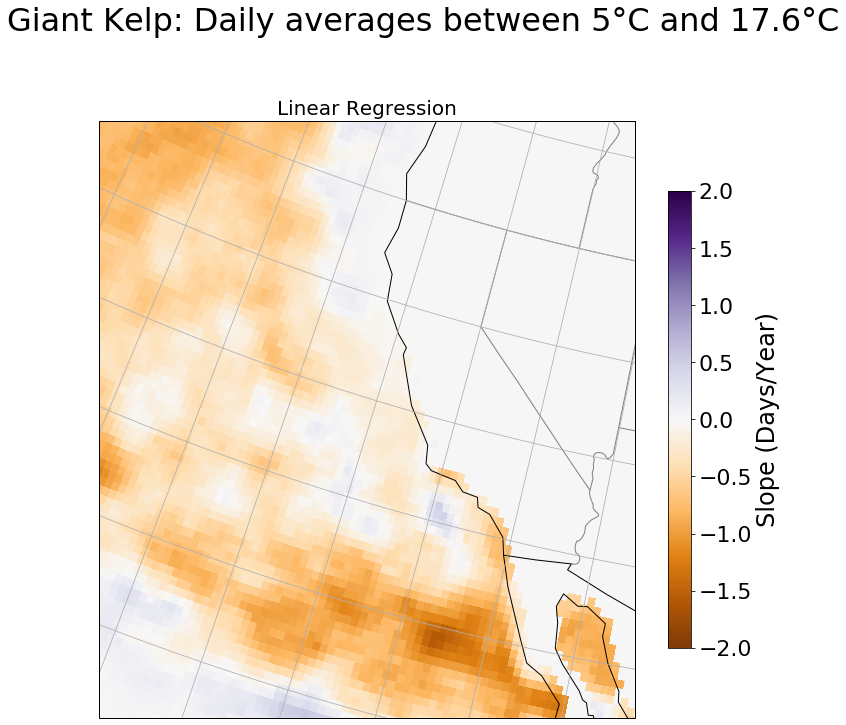

In [29]:
# Creating a fig2ure, change name to species name
fig2 = plt.figure(figsize=[12,12])
fig2.suptitle('Giant Kelp: Daily averages between ' + str(min_Temp) + '\u00b0C and ' + str(max_Temp) + '\u00b0C',fontsize=32)

# Plot the count_Mean data
linreg_Plot_Years = fig2.add_subplot(1,1,1,projection=crs.LambertConformal())
linreg_Plot_Years.set_title('Linear Regression', fontsize=20)
linreg_Plot_Years.set_extent([230,245,28,43], crs.Geodetic())
linreg_Colormesh_Years = linreg_Plot_Years.pcolormesh(lon, lat, NOAA_Slopes_Years.data,
             transform=crs.PlateCarree(),
             cmap='PuOr',vmin = -2, vmax = 2)
linreg_Plot_Years.add_feature(cfeature.COASTLINE)
linreg_Plot_Years.add_feature(cfeature.LAND)
linreg_Plot_Years.add_feature(cfeature.BORDERS)
linreg_Plot_Years.add_feature(states_provinces, edgecolor='gray')
linreg_Plot_Years.gridlines()

# Create a colorbar
colorbar = fig2.colorbar(linreg_Colormesh_Years, shrink=0.7, anchor=('SW'))
colorbar.set_label('Slope (Days/Year)',fontsize=24)
colorbar.ax.tick_params(labelsize=22)

fig2.savefig(r"D:\CRI_Modelling_PC\CRI Maps\linreg2.jpeg", bbox_inches='tight')